# Inflation

We first illustrate the problem.

In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import numpy as np

In [60]:
date_ptr = '2009-03'
inflation_data = []

while date_ptr != '2024-01':
    data = pd.read_parquet(f'/Users/haekim/dev/taxis-and-ubers/data/clean_data/{date_ptr}.parquet')
    average_price = data['fare_amount'].median()
    inflation_data.append({
        'date': date_ptr,
        'average_taxi_fare': average_price
    })

    date_ptr = (pd.to_datetime(date_ptr) + pd.DateOffset(months=1)).strftime("%Y-%m")

inflation_df = pd.DataFrame(inflation_data)
inflation_df['date'] = pd.to_datetime(inflation_df['date'])

Text(0.5, 1.0, 'Taxi fares rise in periods')

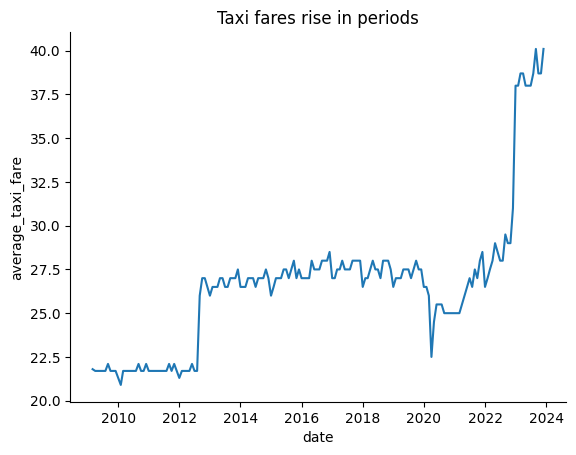

In [61]:
sns.lineplot(x=inflation_df['date'], y=inflation_df['average_taxi_fare'])
sns.despine()
plt.title('Taxi fares rise in periods')

Unfortunately, theres no nice way to deal with this with inflation - as taxi fares are a service and not increased every year along with CPI - there is a stepwise relation. 

Theres clear rises in 2013 and 2022. Let's find manually what these rises were.

In 2013: https://www.nytimes.com/2012/07/10/nyregion/nyc-taxi-panel-to-vote-on-17-rise-in-fares.html
- A rise of 17% occured

In 2022: https://www.nytimes.com/2022/11/17/nyregion/taxi-fare-hike-nyc.html
- A rise in 23% occured

So let us also create a new column with 'adjusted' price, which aligns with the new fares now. Any fares before 2013 must be increased by $1.17 \cdot 1.23 = 1.4391$. Any fares between 2013 and 2023 should be increased by $1.23$

In [81]:
pd.read_parquet('/Users/haekim/dev/taxis-and-ubers/data/clean_data/2023-12.parquet')['fare_amount'].mean()

43.83814175732715

In [87]:
inflation_df[inflation_df['date'] >= pd.to_datetime('2022-01-01')]

,date,average_taxi_fare
156,2022-01-01,32.595
157,2022-02-01,33.210
158,2022-03-01,33.825
159,2022-04-01,34.440
160,2022-05-01,35.670
161,2022-06-01,35.055
162,2022-07-01,34.440
163,2022-08-01,34.440
164,2022-09-01,36.285
165,2022-10-01,35.670


Text(0.5, 1.0, 'Taxi fares rise in periods')

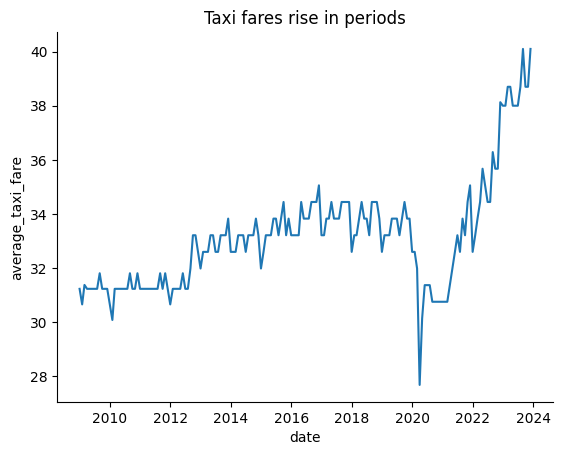

In [ ]:
sns.lineplot(x=inflation_df['date'], y=inflation_df['average_taxi_fare'])
sns.despine()
plt.title('Taxi fares ')

Now the above looks more in line with CPI (or inflation). We'll deal with this later on in our actual analysis. 

Saving the data

In [165]:
date_ptr = '2009-01'

while date_ptr != '2024-01':
    data = pd.read_parquet(f'/Users/haekim/dev/taxis-and-ubers/data/clean_data/{date_ptr}.parquet')
    date_obj = pd.to_datetime(date_ptr)
    adjusted_fare = data['fare_amount']
    if date_obj < pd.Timestamp("2012-09-01"):
        adjusted_fare *= 1.4391  
    elif date_obj < pd.Timestamp("2023-01-01"):
        adjusted_fare *= 1.23
    data['fare_amount_adjusted'] = adjusted_fare
    data.to_parquet(f'/Users/haekim/dev/taxis-and-ubers/data/clean_data_adjusted/{date_ptr}.parquet')
    date_ptr = (date_obj + pd.DateOffset(months=1)).strftime("%Y-%m")

#### Geo-location data

In [166]:
location_data = pd.read_parquet(f'/Users/haekim/dev/taxis-and-ubers/data/metadata/taxi_zone_lookup_extra.parquet')

In [167]:
location_data['longitude'] = location_data['Coordinate'].apply(lambda x: x[0] if x is not None else None)
location_data['latitude'] = location_data['Coordinate'].apply(lambda x: x[1] if x is not None else None)

In [168]:
longitude_map = location_data[['LocationID', 'longitude']].set_index('LocationID')['longitude'].to_dict()
latitude_map = location_data[['LocationID', 'latitude']].set_index('LocationID')['latitude'].to_dict()

In [169]:
location_data

,LocationID,Borough,Zone,service_zone,Coordinate,longitude,latitude
0,1,EWR,Newark Airport,EWR,"[-74.17725485035348, 40.68906405]",-74.177255,40.689064
1,2,Queens,Jamaica Bay,Boro Zone,"[-73.8354124, 40.6039936]",-73.835412,40.603994
2,3,Bronx,Allerton,Boro Zone,"[-73.8673652, 40.8654299]",-73.867365,40.865430
3,4,Manhattan,Alphabet City,Yellow Zone,"[-73.9795833, 40.7251022]",-73.979583,40.725102
4,5,Staten Island,Arden Heights,Boro Zone,"[-74.1916031653169, 40.563699850000006]",-74.191603,40.563700
...,...,...,...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone,"[-74.012527, 40.7119004]",-74.012527,40.711900
261,262,Manhattan,Yorkville East,Yellow Zone,"[-73.96129216673927, 40.776654449999995]",-73.961292,40.776654
262,263,Manhattan,Yorkville West,Yellow Zone,None,NaN,NaN
263,264,Unknown,None,None,"[46.7981241, -19.6650426]",46.798124,-19.665043


In [170]:
location_data['longitude'] = location_data['Coordinate'].apply(lambda x: x[0] if x is not None else None)
location_data['latitude'] = location_data['Coordinate'].apply(lambda x: x[1] if x is not None else None)

In [171]:
date_ptr = '2009-01'

while date_ptr != '2024-01':
    data = pd.read_parquet(f'/Users/haekim/dev/taxis-and-ubers/data/clean_data/{date_ptr}.parquet')
    if 'PULocationID' in data:
        # need to assign pickup and dropoff longitude and latitude
        data['pickup_longitude'] = data['PULocationID'].apply(lambda x: longitude_map[x])
        data['pickup_latitude'] = data['PULocationID'].apply(lambda x: latitude_map[x])
        data['dropoff_longitude'] = data['DOLocationID'].apply(lambda x: longitude_map[x])
        data['dropoff_latitude'] = data['DOLocationID'].apply(lambda x: latitude_map[x])

    data.to_parquet(f'/Users/haekim/dev/taxis-and-ubers/data/clean_data_adjusted_geo/{date_ptr}.parquet')
    date_ptr = (pd.to_datetime(date_ptr) + pd.DateOffset(months=1)).strftime("%Y-%m")